In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [2]:
df = pd.read_csv('us-states.csv')

In [3]:
# Sort to choose which states to consider
# df.groupby(['state']).sum().sort_values(by=['deaths'])

States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

In [4]:
California = df[df['state']=='California']
NewYork = df[df['state']=='New York']
Texas = df[df['state']=='Texas']

Virginia = df[df['state']=='Virginia']

NorthernMarianaIslands = df[df['state']=='Northern Mariana Islands']
VirginIslands= df[df['state']=='Virgin Islands']
Guam= df[df['state']=='Guam']

# Preprocessing Data

In [5]:
state = 'VA'
cases_deaths  = Virginia[['cases','deaths']].to_numpy()
cases_deaths[:,0]= cumulative_to_daily(cases_deaths[:,0])
cases_deaths[:,1]= cumulative_to_daily(cases_deaths[:,1])

scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
cases_deaths = scaler.fit_transform(cases_deaths)

In [6]:
scaler.data_max_

array([9914.,  383.])

In [7]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [8]:
cases_deaths=cases_deaths[13:] # Skip the first days where there's no data

In [9]:
window_size = 40

X,Y = convert_to_slide_window(cases_deaths,window_size)
split = int(len(X) * 0.8)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Daily + Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Daily + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# TST Model

In [10]:
TST_model = TimeSeriesTransformer(n_features=2,d_model=128, n_heads=4, n_hidden=128, n_layers=4 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}'.format(state)))

Epoch 1 Loss is 0.49346836739116245
Epoch 2 Loss is 0.28268440895610386
Epoch 3 Loss is 0.15698351628250545
Epoch 4 Loss is 0.0909219847785102
Epoch 5 Loss is 0.06288599802388085
Epoch 6 Loss is 0.054231281495756574
Epoch 7 Loss is 0.051828970511754356
Epoch 8 Loss is 0.05032169653309716
Epoch 9 Loss is 0.0491978886226813
Epoch 10 Loss is 0.04815656691789627
Epoch 11 Loss is 0.047093994501564235
Epoch 12 Loss is 0.045626302146249346
Epoch 13 Loss is 0.04431373874346415
Epoch 14 Loss is 0.04296602143181695
Epoch 15 Loss is 0.041282242784897484
Epoch 16 Loss is 0.03982069074279732
Epoch 17 Loss is 0.03814095093144311
Epoch 18 Loss is 0.03630072023305628
Epoch 19 Loss is 0.03439042924178971
Epoch 20 Loss is 0.032762557889024414
Epoch 21 Loss is 0.030868446454405785
Epoch 22 Loss is 0.02880047634243965
Epoch 23 Loss is 0.02708149039083057
Epoch 24 Loss is 0.025519223055905767
Epoch 25 Loss is 0.02419917657971382
Epoch 26 Loss is 0.02306237444281578
Epoch 27 Loss is 0.02198159435970916
Epoc

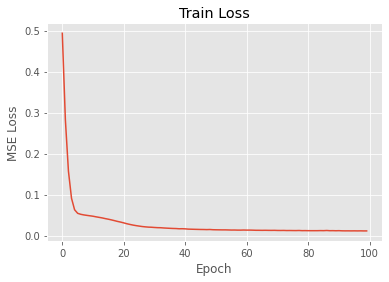

In [11]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [12]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print(predicted.shape)
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test).cpu().detach().numpy()

torch.Size([40, 72, 2])
TST: Test MSE Loss:  0.0787222757935524


In [13]:
X_train[-1].shape

torch.Size([40, 2])

In [14]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.3598, device='cuda:0', grad_fn=<MseLossBackward>)


In [15]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 398978 Parameters for the transformer model


In [16]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST)

In [17]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_TST[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_TST[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_TST[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_TST[:,1]))

R2 Score for Cases 0.45013617326796584
MAPE Score for Cases 0.32435873
R2 Score for Deaths -0.6229846478680792
MAPE Score for Deaths 0.9265175


# LSTM Model

In [18]:
LSTM_model = COVID_LSTM(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}'.format(state)))

Epoch 1 Loss is 0.7025699085659451
Epoch 2 Loss is 0.6510997282134162
Epoch 3 Loss is 0.5945238669713339
Epoch 4 Loss is 0.5229457947942946
Epoch 5 Loss is 0.4180528157287174
Epoch 6 Loss is 0.24895984596676296
Epoch 7 Loss is 0.0762216051419576
Epoch 8 Loss is 0.0653357385761208
Epoch 9 Loss is 0.054598370153043
Epoch 10 Loss is 0.04696975193089909
Epoch 11 Loss is 0.0463865055806107
Epoch 12 Loss is 0.0442930224041144
Epoch 13 Loss is 0.042971675387687154
Epoch 14 Loss is 0.041386505795849696
Epoch 15 Loss is 0.039705281870232687
Epoch 16 Loss is 0.037666814815666944
Epoch 17 Loss is 0.03512764742804898
Epoch 18 Loss is 0.03204584659801589
Epoch 19 Loss is 0.02835246009959115
Epoch 20 Loss is 0.02438536938279867
Epoch 21 Loss is 0.02102874115937286
Epoch 22 Loss is 0.018005731101665232
Epoch 23 Loss is 0.016481491840547986
Epoch 24 Loss is 0.01573053602543142
Epoch 25 Loss is 0.015171747344235579
Epoch 26 Loss is 0.014865290994445482
Epoch 27 Loss is 0.014623672960119115
Epoch 28 Los

In [19]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test).cpu().detach().numpy()

LSTM: Test MSE Loss:  0.09905707091093063


In [20]:
X_test.shape

torch.Size([72, 40, 2])

In [21]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.2380, device='cuda:0', grad_fn=<MseLossBackward>)


In [22]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM)

In [23]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_LSTM[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_LSTM[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_LSTM[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_LSTM[:,1]))

R2 Score for Cases -1.0281203848814724
MAPE Score for Cases 0.5973116
R2 Score for Deaths -1.0713446255859838
MAPE Score for Deaths 0.80896866


# GRU Model

In [24]:
GRU_model = COVID_GRU(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}'.format(state)))

Epoch 1 Loss is 0.7031692730055915
Epoch 2 Loss is 0.5516417357656691
Epoch 3 Loss is 0.3986247181892395
Epoch 4 Loss is 0.2398451699150933
Epoch 5 Loss is 0.1110305248035325
Epoch 6 Loss is 0.05274260251058473
Epoch 7 Loss is 0.04677879292931822
Epoch 8 Loss is 0.045402690975202456
Epoch 9 Loss is 0.042658844548794955
Epoch 10 Loss is 0.041279324433869787
Epoch 11 Loss is 0.040124735691481166
Epoch 12 Loss is 0.038876185193657875
Epoch 13 Loss is 0.03758483442167441
Epoch 14 Loss is 0.03623542603519228
Epoch 15 Loss is 0.034619908986820117
Epoch 16 Loss is 0.032814442904459104
Epoch 17 Loss is 0.030832908633682463
Epoch 18 Loss is 0.028705142438411713
Epoch 19 Loss is 0.026232096470064588
Epoch 20 Loss is 0.023777163690990873
Epoch 21 Loss is 0.02147518263922797
Epoch 22 Loss is 0.018720623726646107
Epoch 23 Loss is 0.01654540530095498
Epoch 24 Loss is 0.015323664475646284
Epoch 25 Loss is 0.014727123288644684
Epoch 26 Loss is 0.014449928783708148
Epoch 27 Loss is 0.014262402326696448

In [25]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test).cpu().detach().numpy()

GRU: Test MSE Loss:  0.0794500857591629


In [26]:
X_test.shape

torch.Size([72, 40, 2])

In [27]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.1951, device='cuda:0', grad_fn=<MseLossBackward>)


In [28]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU)

In [29]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_GRU[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_GRU[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_GRU[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_GRU[:,1]))

R2 Score for Cases 0.8854390566905309
MAPE Score for Cases 0.23238367
R2 Score for Deaths -1.131904520711076
MAPE Score for Deaths 0.7773428


# Plots

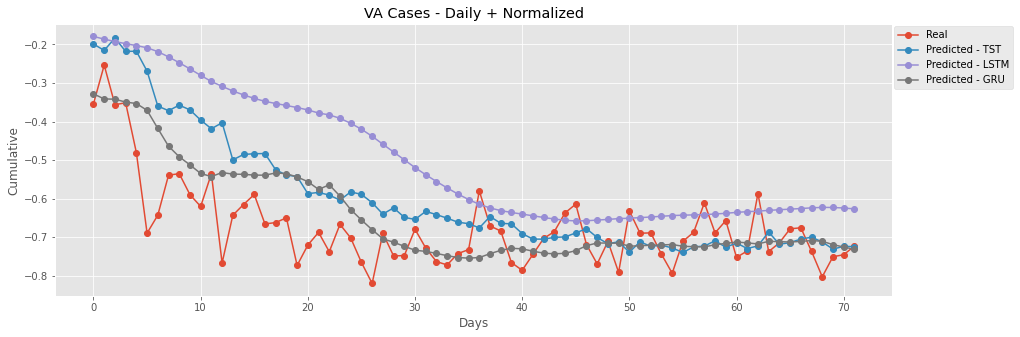

In [30]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

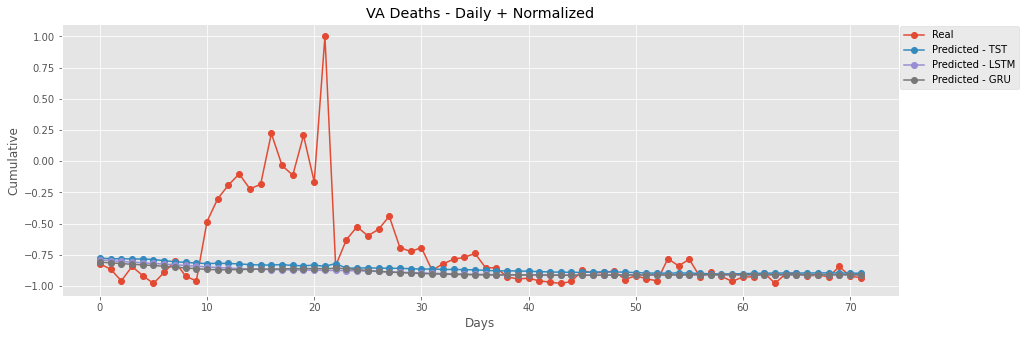

In [31]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,1].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,1],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,1].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

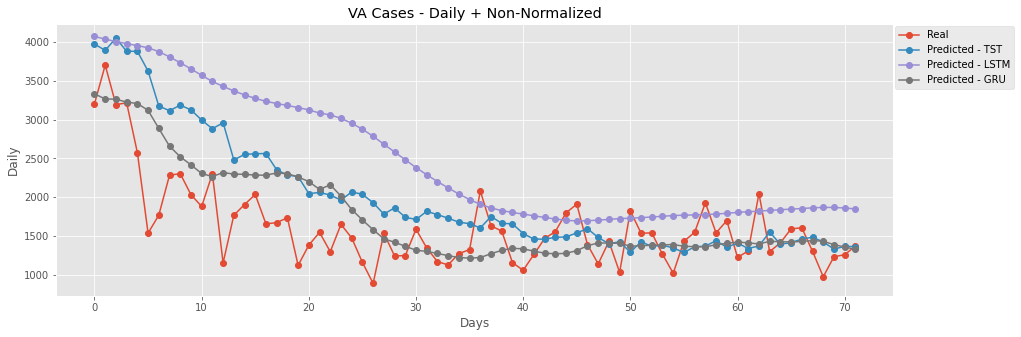

In [32]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

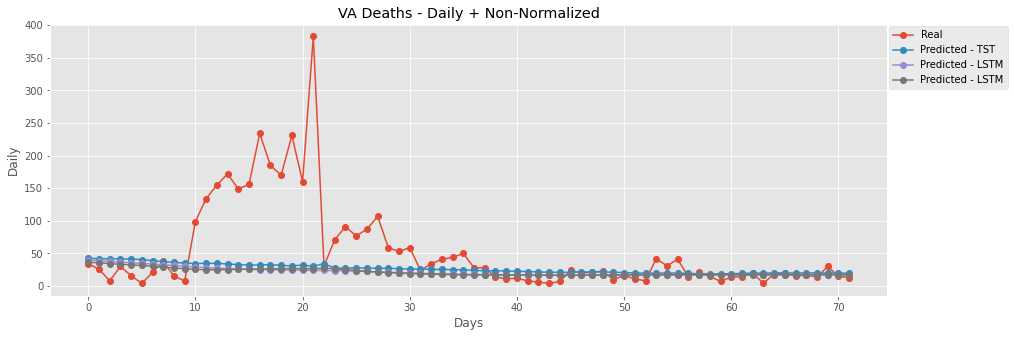

In [33]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,1],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,1],label='Predicted - LSTM',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()